<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/product-analytics/cohort_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cohort Analysis in Python

Cohort analysis is a very useful and relatively simple technique that helps to get valuable insights about customers. Different metrics can be used for this analysis: conversion, retention, revenue, etc.

A **cohort** is considered a group of customers sharing some characteristics in common, such as sign-up date, geographical location, acquisition channel, and so on. **Cohort Analysis** tracks these cohorts over time to identify some common patterns or behaviors.

When conducting the cohort analysis, it is crucial to consider the relationship between the metric we are tracking and the business model. Depending on the company's goals, we can focus on user retention, conversion ration, revenue, etc. 

Furthermore, cohort analysis can also help to observe the impact of changes in the product on the user behavior under analysis. Potentially being able to measure the impact of product updates or new features. We should be able to observe is the improvement efforts had some effect on the users' behaviors.

In [0]:
#@title ## Setup
#@markdown * Import dependencies
#@markdown * Download dataset (UCI Online Retail II Data Set)
#@markdown ---
#@markdown **Data Set Information:**
#@markdown This Online Retail II data set contains all the transactions 
#@markdown occurring for a UK-based and registered, non-store online retail 
#@markdown between 01/12/2009 and 09/12/2011.The company mainly sells unique 
#@markdown all-occasion gift-ware. Many customers of the company are wholesalers.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import matplotlib.colors as mcolors

from operator import attrgetter


!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx -q


In [0]:
df = pd.read_excel('Online Retail.xlsx', 
                   dtype={'CustomerID': str,  'InvoiceID': str},
                   parse_dates=['InvoiceDate'],
                   infer_datetime_format=True)

In [42]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [0]:
df.dropna(subset=['CustomerID'], inplace=True)

In [45]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Quantity,406829.0,12.061303,248.693370,-80995.0,2.00,5.00,12.00,80995.0
UnitPrice,406829.0,3.460471,69.315162,0.0,1.25,1.95,3.75,38970.0


In [0]:
df = df[df['Quantity'] > 0]

In [47]:
n_orders = df.groupby(['CustomerID'])['InvoiceNo'].nunique()
n_orders

CustomerID
12346     1
12347     7
12348     4
12349     1
12350     1
         ..
18280     1
18281     1
18282     2
18283    16
18287     3
Name: InvoiceNo, Length: 4339, dtype: int64

In [48]:
mult_orders_perc = np.sum(n_orders > 1) / df['CustomerID'].nunique()
print(f'% of customers with multiple orders: {mult_orders_perc * 100:.2f}')

% of customers with multiple orders: 65.57


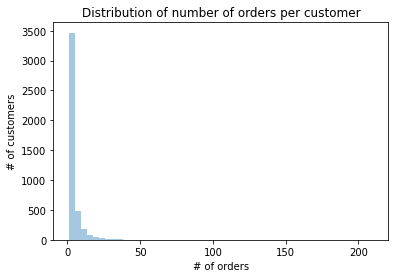

In [49]:
ax = sns.distplot(n_orders, kde=False, hist=True)

ax.set(title='Distribution of number of orders per customer',

       xlabel='# of orders', 

       ylabel='# of customers');

In [50]:
n_orders[n_orders>200]

CustomerID
12748    210
14911    201
Name: InvoiceNo, dtype: int64

The dataset we are using for this example does not contain the customer sign-up date — the date when they registered with the retailer. That is why we assume that the cohort they belong to is based on the first purchase date. A possible downside of this approach is that the dataset does not contain the past data, and what we already see in this snapshot (between 01/12/2010 and 09/12/2011) includes recurring clients. In other words, the first purchase we see in this dataset might not be the actual first purchase of a given client. However, there is no way to account for this without having access to the entire historical dataset of the retailer.
As the first step, we keep only the relevant columns and drop duplicated values — one order (indicated by InvoiceNo) can contain multiple items (indicated by StockCode).

In [53]:
df = df[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()
df.describe().transpose()

,count,unique,top,freq,first,last
CustomerID,18566,4339,12748,211,NaT,NaT
InvoiceNo,18566,18536,578548,2,NaT,NaT
InvoiceDate,18566,17286,2011-10-21 14:41:00,4,2010-12-01 08:26:00,2011-12-09 12:50:00


As the second step, we create the cohort and order_month variables. The first one indicates the monthly cohort based on the first purchase date (calculated per customer). The latter one is the truncated month of the purchase date.

In [56]:
df['order_month'] = df['InvoiceDate'].dt.to_period('M')
df['cohort'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')
df.head() 

,CustomerID,InvoiceNo,InvoiceDate,cohort,order_month
0,17850,536365,2010-12-01 08:26:00,2010-12,2010-12
7,17850,536366,2010-12-01 08:28:00,2010-12,2010-12
9,13047,536367,2010-12-01 08:34:00,2010-12,2010-12
21,13047,536368,2010-12-01 08:34:00,2010-12,2010-12
25,13047,536369,2010-12-01 08:35:00,2010-12,2010-12


Then, we aggregate the data per cohort and order_month and count the number of unique customers in each group. Additionally, we add the period_number, which indicates the number of periods between the cohort month and the month of the purchase.

In [64]:
df_cohort = df.groupby(['cohort', 'order_month']) \
  .agg(n_customers=('CustomerID', 'nunique')) \
  .reset_index(drop=False)

df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))
df_cohort.head()

,cohort,order_month,n_customers,period_number
0,2010-12,2010-12,885,0
1,2010-12,2011-01,324,1
2,2010-12,2011-02,286,2
3,2010-12,2011-03,340,3
4,2010-12,2011-04,321,4


The next step is to pivot the df_cohort table in a way that each row contains information about a given cohort and each column contains values for a certain period.

In [63]:
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')
cohort_pivot.head(10)

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


To obtain the retention matrix, we need to divide the values each row by the row's first value, which is actually the cohort size — all customers who made their first purchase in the given month.

In [65]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
retention_matrix.head()

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,1.0,0.366102,0.323164,0.384181,0.362712,0.397740,0.362712,0.349153,0.353672,0.395480,0.374011,0.502825,0.265537
2011-01,1.0,0.220624,0.266187,0.230216,0.321343,0.287770,0.247002,0.242206,0.299760,0.326139,0.364508,0.117506,NaN
2011-02,1.0,0.186842,0.186842,0.284211,0.271053,0.247368,0.252632,0.278947,0.247368,0.305263,0.068421,NaN,NaN
2011-03,1.0,0.150442,0.252212,0.199115,0.223451,0.168142,0.267699,0.230088,0.278761,0.086283,NaN,NaN,NaN
2011-04,1.0,0.213333,0.203333,0.210000,0.196667,0.226667,0.216667,0.260000,0.073333,NaN,NaN,NaN,NaN


Lastly, we plot the retention matrix as a heatmap. Additionally, we wanted to include extra information regarding the cohort size. That is why we in fact created two heatmaps, where the one indicating the cohort size is using a white only colormap — no coloring at all.

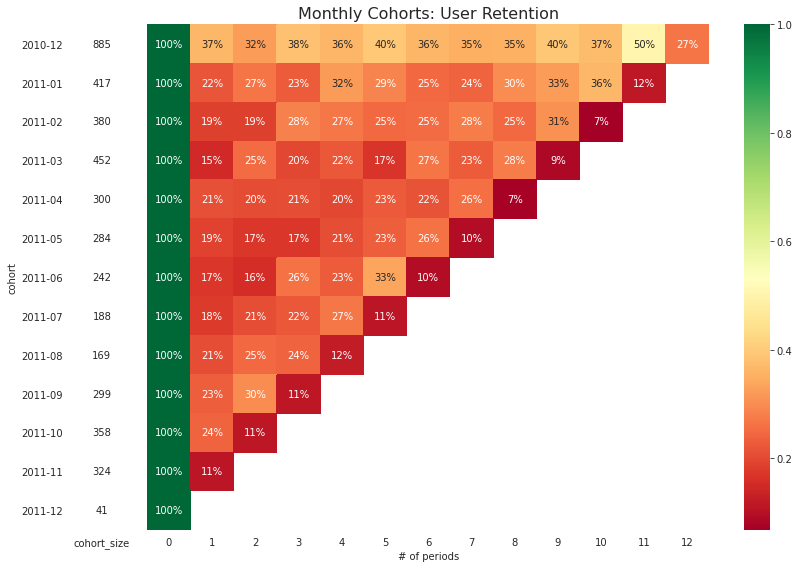

In [66]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])

    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])

    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()